In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2  # will autoreload all packages imported with %aimport

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from pickle import load as pload
from json import load as load_json

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src

from src.model.hydroshoot_experiment import load_runs, HydroShootExperiment

## Loading experiment data

In [3]:
EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/fixed_predawn_7days_jun_jul_aug'
assert(os.path.isdir(EXPERIMENT_ROOT))

In [4]:
# Loading all the data
runs = load_runs(EXPERIMENT_ROOT)
print(len(runs))

84


In [5]:
print(runs[0])
print('Targets:', runs[0].get_targets())
print('Variables:', runs[0].get_state_variables())

HydroShootExperiment(n_steps=168, state_size=360)
Targets: ('input_Tac', 'input_u', 'input_hs', 'input_Rg', 'output_Rg', 'output_An', 'output_E', 'output_Tleaf')
Variables: ('Ci', 'gb', 'Ei', 'FluxC', 'Tlc', 'An', 'Flux', 'psi_head', 'u', 'E', 'Eabs', 'gs', 'par_photo.dHd')


## Training a single readout functions

In [6]:
from src.learning.preprocessing import generate_mask

STATE_VAR = 'Tlc'
TARGET = 'output_Rg'
STATE_SIZE = 64
SAMPLES_PER_RUN = 1
WARMUP_STEPS = 24
N_CV_GROUPS = 3
DAYLIGHT_MASK = generate_mask(5, 21)

In [7]:
"""Preprocess data into 2D and 1D arrays + define fold groups."""

from src.learning.preprocessing import preprocess_data, reshape_data
from src.learning.grouping import alternating_groups

X, y = preprocess_data(runs, STATE_VAR, TARGET,
    state_size=STATE_SIZE,
    samples_per_run=SAMPLES_PER_RUN,
    warmup_steps=WARMUP_STEPS,
    mask=DAYLIGHT_MASK,
)

X_train, y_train = reshape_data(X, y)
groups = alternating_groups(X, n_groups=N_CV_GROUPS)

n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape

print(f'Extracted dataset:'
      f'\n  {n_runs:>3} runs'
      f'\n  {n_days:>3} days per run'
      f'\n  {n_steps:>3} steps per day'
      f'\n  {n_variables:>3} observed state variables'
      f'\n  {n_state_samples:>3} samples per reservoir\n'
      )

print('X_train: ', X_train.shape)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print( 'groups: ', groups.shape)

Extracted dataset:
   84 runs
    6 days per run
   16 steps per day
   64 observed state variables
    1 samples per reservoir

X_train:  (8064, 64)
X_train:  (8064, 64)
y_train:  (8064,)
groups:  (8064,)


In [8]:
"""Define cross-validation folds."""

from sklearn.model_selection import LeaveOneGroupOut

folds = LeaveOneGroupOut()

In [9]:
 """Define readout model pipeline and hyperparameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 100)
}]

In [10]:
"""Get model scores before and after hyperparameter optimization."""

from src.learning.training import get_cv_score, perform_gridsearch

cv_scores = get_cv_score(readout, X_train, y_train, groups, folds, verbose=True)
tuned_readout, tuned_cv_scores = perform_gridsearch(readout, X_train, y_train, groups, folds, search_grid, verbose=True)

Cross-validation scores:
  - Train: -0.6479 +/- 0.01982
  - CV:    -0.7334 +/- 0.05718
Cross-validation scores after tuning:
  - Train: -0.6596 +/- 0.02053
  - CV:    -0.7248 +/- 0.05703
Optimal hyperparameters:
  - ridge_regression__alpha = 291.50530628251755


## Training readout functions for all combinations of task + variable

In [11]:
from src.learning.preprocessing import generate_mask

STATE_SIZE = 64
SAMPLES_PER_RUN = 1
WARMUP_STEPS = 24
N_CV_GROUPS = 3
DAYLIGHT_MASK = generate_mask(5, 21)

In [12]:
 """Define readout model pipeline and hyperparameter search grid."""

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Define model
readout = Pipeline([
  ('ridge_regression', Ridge(alpha=1, fit_intercept=True))
])

# define search grid
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 100)
}]

In [13]:


from src.learning.preprocessing import preprocess_data, reshape_data
from src.learning.grouping import alternating_groups
from src.learning.training import get_cv_score, perform_gridsearch
from src.constants import HYDROSHOOT_STATE_VARIABLES

targets = sorted(runs[0].get_targets())
variables = HYDROSHOOT_STATE_VARIABLES

scores = []  # insert tuples of (target_name, variable_name, tuned_model, untuned_score, tuned_score)
for target in targets:
  for var in variables:
    X, y = preprocess_data(runs, var, target, state_size=STATE_SIZE, samples_per_run=SAMPLES_PER_RUN,
                           warmup_steps=WARMUP_STEPS, mask=DAYLIGHT_MASK)
    X_train, y_train = reshape_data(X, y)
    groups = alternating_groups(X, n_groups=N_CV_GROUPS)
    cv_scores = get_cv_score(readout, X_train, y_train, groups, folds, verbose=False)
    tuned_readout, tuned_cv_scores = perform_gridsearch(readout, X_train, y_train, groups, folds, search_grid, verbose=False)
    scores.append((target, var, tuned_readout, cv_scores, tuned_cv_scores))
    print(f'{f"[{target}, {var}]":<20} CV-score (tuned): {tuned_cv_scores[1][0]:.4f} +/- {tuned_cv_scores[1][1]:.5f}')

[input_Rg, An]       CV-score (tuned): -0.6978 +/- 0.04619
[input_Rg, Ei]       CV-score (tuned): -0.6833 +/- 0.05569
[input_Rg, u]        CV-score (tuned): -0.9614 +/- 0.03405
[input_Rg, Tlc]      CV-score (tuned): -0.7054 +/- 0.04877
[input_Rg, Flux]     CV-score (tuned): -0.6996 +/- 0.05438
[input_Rg, Eabs]     CV-score (tuned): -0.6837 +/- 0.05922
[input_Rg, gs]       CV-score (tuned): -0.7071 +/- 0.04580
[input_Rg, E]        CV-score (tuned): -0.6964 +/- 0.05573
[input_Rg, gb]       CV-score (tuned): -0.9464 +/- 0.05211
[input_Rg, psi_head] CV-score (tuned): -0.7081 +/- 0.05476
[input_Rg, FluxC]    CV-score (tuned): -0.6998 +/- 0.05153
[input_Tac, An]      CV-score (tuned): -0.6511 +/- 0.04697
[input_Tac, Ei]      CV-score (tuned): -0.7681 +/- 0.03338
[input_Tac, u]       CV-score (tuned): -0.9662 +/- 0.00855
[input_Tac, Tlc]     CV-score (tuned): -0.4782 +/- 0.08204
[input_Tac, Flux]    CV-score (tuned): -0.6380 +/- 0.05627
[input_Tac, Eabs]    CV-score (tuned): -0.7666 +/- 0.025

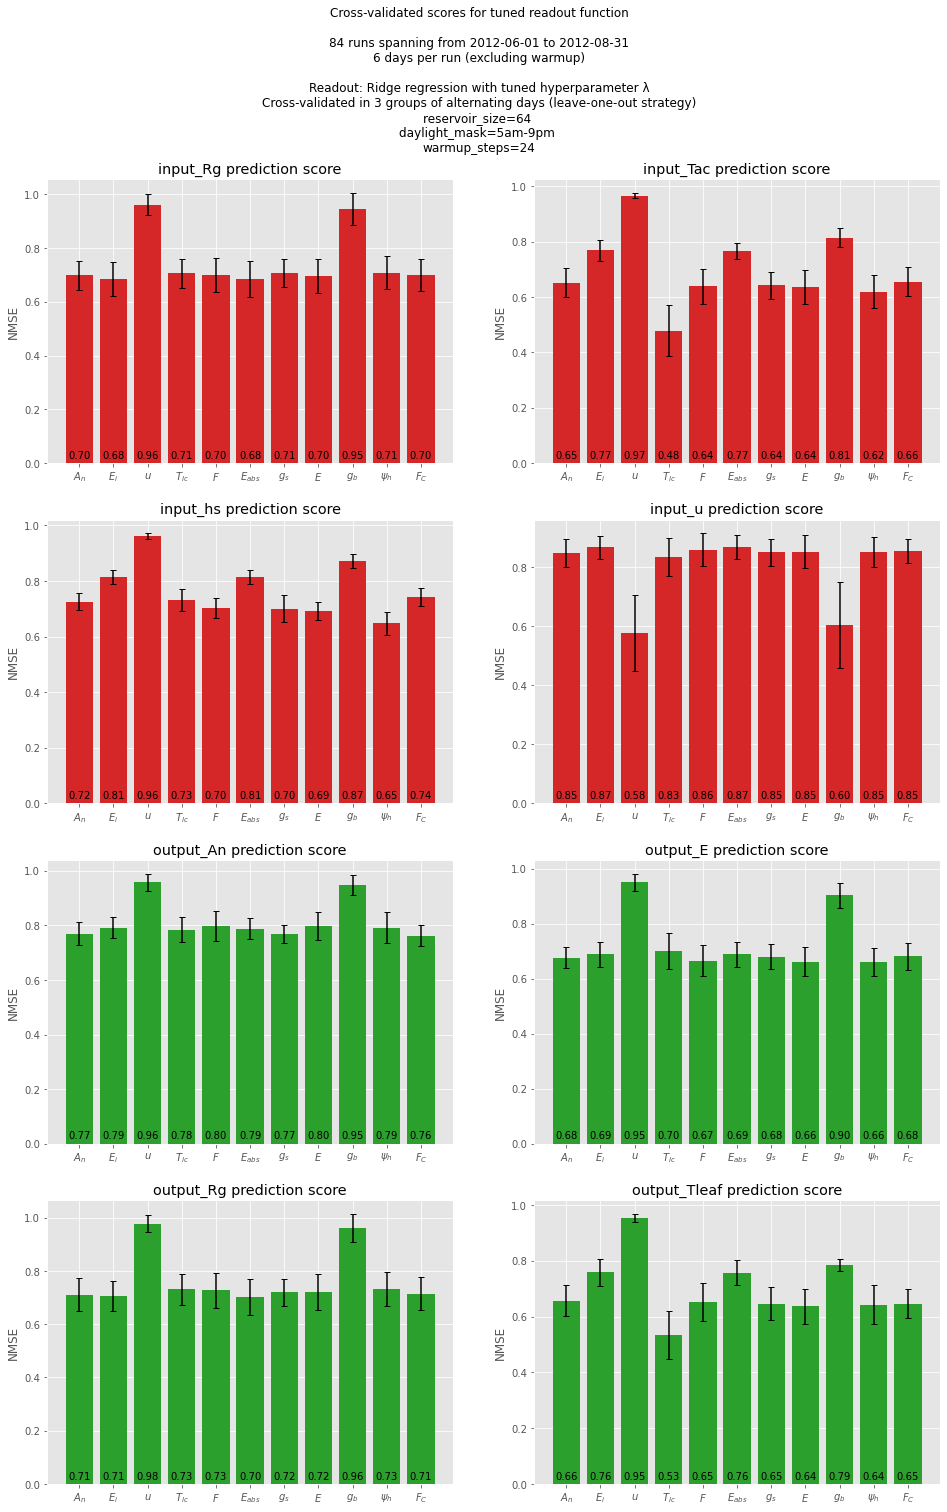

In [14]:
from util import VARIABLE_NAMES


def autolabel(ax, rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{:.2f}'.format(height),
                # xy=(rect.get_x() + rect.get_width() / 2, height),
                xy=(rect.get_x() + rect.get_width() / 2, 0),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


with plt.style.context('ggplot'):
  fig, ax = plt.subplots(4, 2, figsize=(16, 24))

  pos = np.arange(len(variables))
  ax_rects = []

  for i, target in enumerate(targets):
    row = i // 2
    col = i % 2

    tuned_score_means = np.array([score_tuned[1][0] for (name_target, name_var, _, score_untuned, score_tuned) in scores if name_target == target])
    tuned_score_stdev = np.array([score_tuned[1][1] for (name_target, name_var, _, score_untuned, score_tuned) in scores if name_target == target])
    tuned_score_conf = 1.96 * tuned_score_stdev / np.sqrt(N_CV_GROUPS)
    
    color = 'tab:red' if target.startswith('input') else 'tab:green'
    rects = ax[row, col].bar(pos, -np.array(tuned_score_means), 0.8, yerr=tuned_score_conf, color=color, capsize=3)
    ax_rects.append((ax[row, col], rects))

    ax[row, col].set_title(f'{target} prediction score')
    ax[row, col].set_xticks(pos)
    variable_names = [name_var for (name_target, name_var, _, score_untuned, score_tuned) in scores if name_target == target]
    variable_names = [VARIABLE_NAMES[v] for v in variable_names]
    ax[row, col].set_xticklabels(variable_names)
    ax[row, col].set_ylabel('NMSE')

  for ax, rects in ax_rects:
    autolabel(ax, rects)
  

  n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape
  fig.suptitle(f'Cross-validated scores for tuned readout function'
               f'\n\n{n_runs} runs spanning from 2012-06-01 to 2012-08-31'
               f'\n{n_days} days per run (excluding warmup)'
               f'\n\nReadout: Ridge regression with tuned hyperparameter λ'
               f'\nCross-validated in {N_CV_GROUPS} groups of alternating days (leave-one-out strategy)'
               f'\nreservoir_size={n_variables} \ndaylight_mask=5am-9pm \nwarmup_steps={WARMUP_STEPS}'
              )
  plt.show()